# Prediction of Employee Attrition

### This work was written with the aim of creating a program that predicts attrition employees on an open data set  (https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset)

 Libraries and colors for data visualization which was used in this work

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
%matplotlib inline
color_pallete = ["#1e3257", "#f29d52", "#dbe5e6", "#f3c660", "#be4f27", "#addae0"]

sns.set_palette(color_pallete)

## Part one: Exploratory Data Analysis

In [77]:
data = pd.read_csv('/Users/kseniayakunina/Downloads/WA_Fn-UseC_-HR-Employee-Attrition.csv', delimiter=",")
data1_ = data.copy() # downloading dataset

In [80]:
categ = data.columns[data.dtypes == 'object']
nums = data.columns[data.dtypes == 'float64'].union(data.columns[data.dtypes == 'int64'])

In [6]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


There are 3 constant features in this data set, they are useless for analisis.
That is why we can drop it from dataset. Also Employee number we can use as index.

In [78]:
data.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis = 1, inplace=True)

In [79]:
data = data.set_index('EmployeeNumber')

Let's look at the Features more closely.

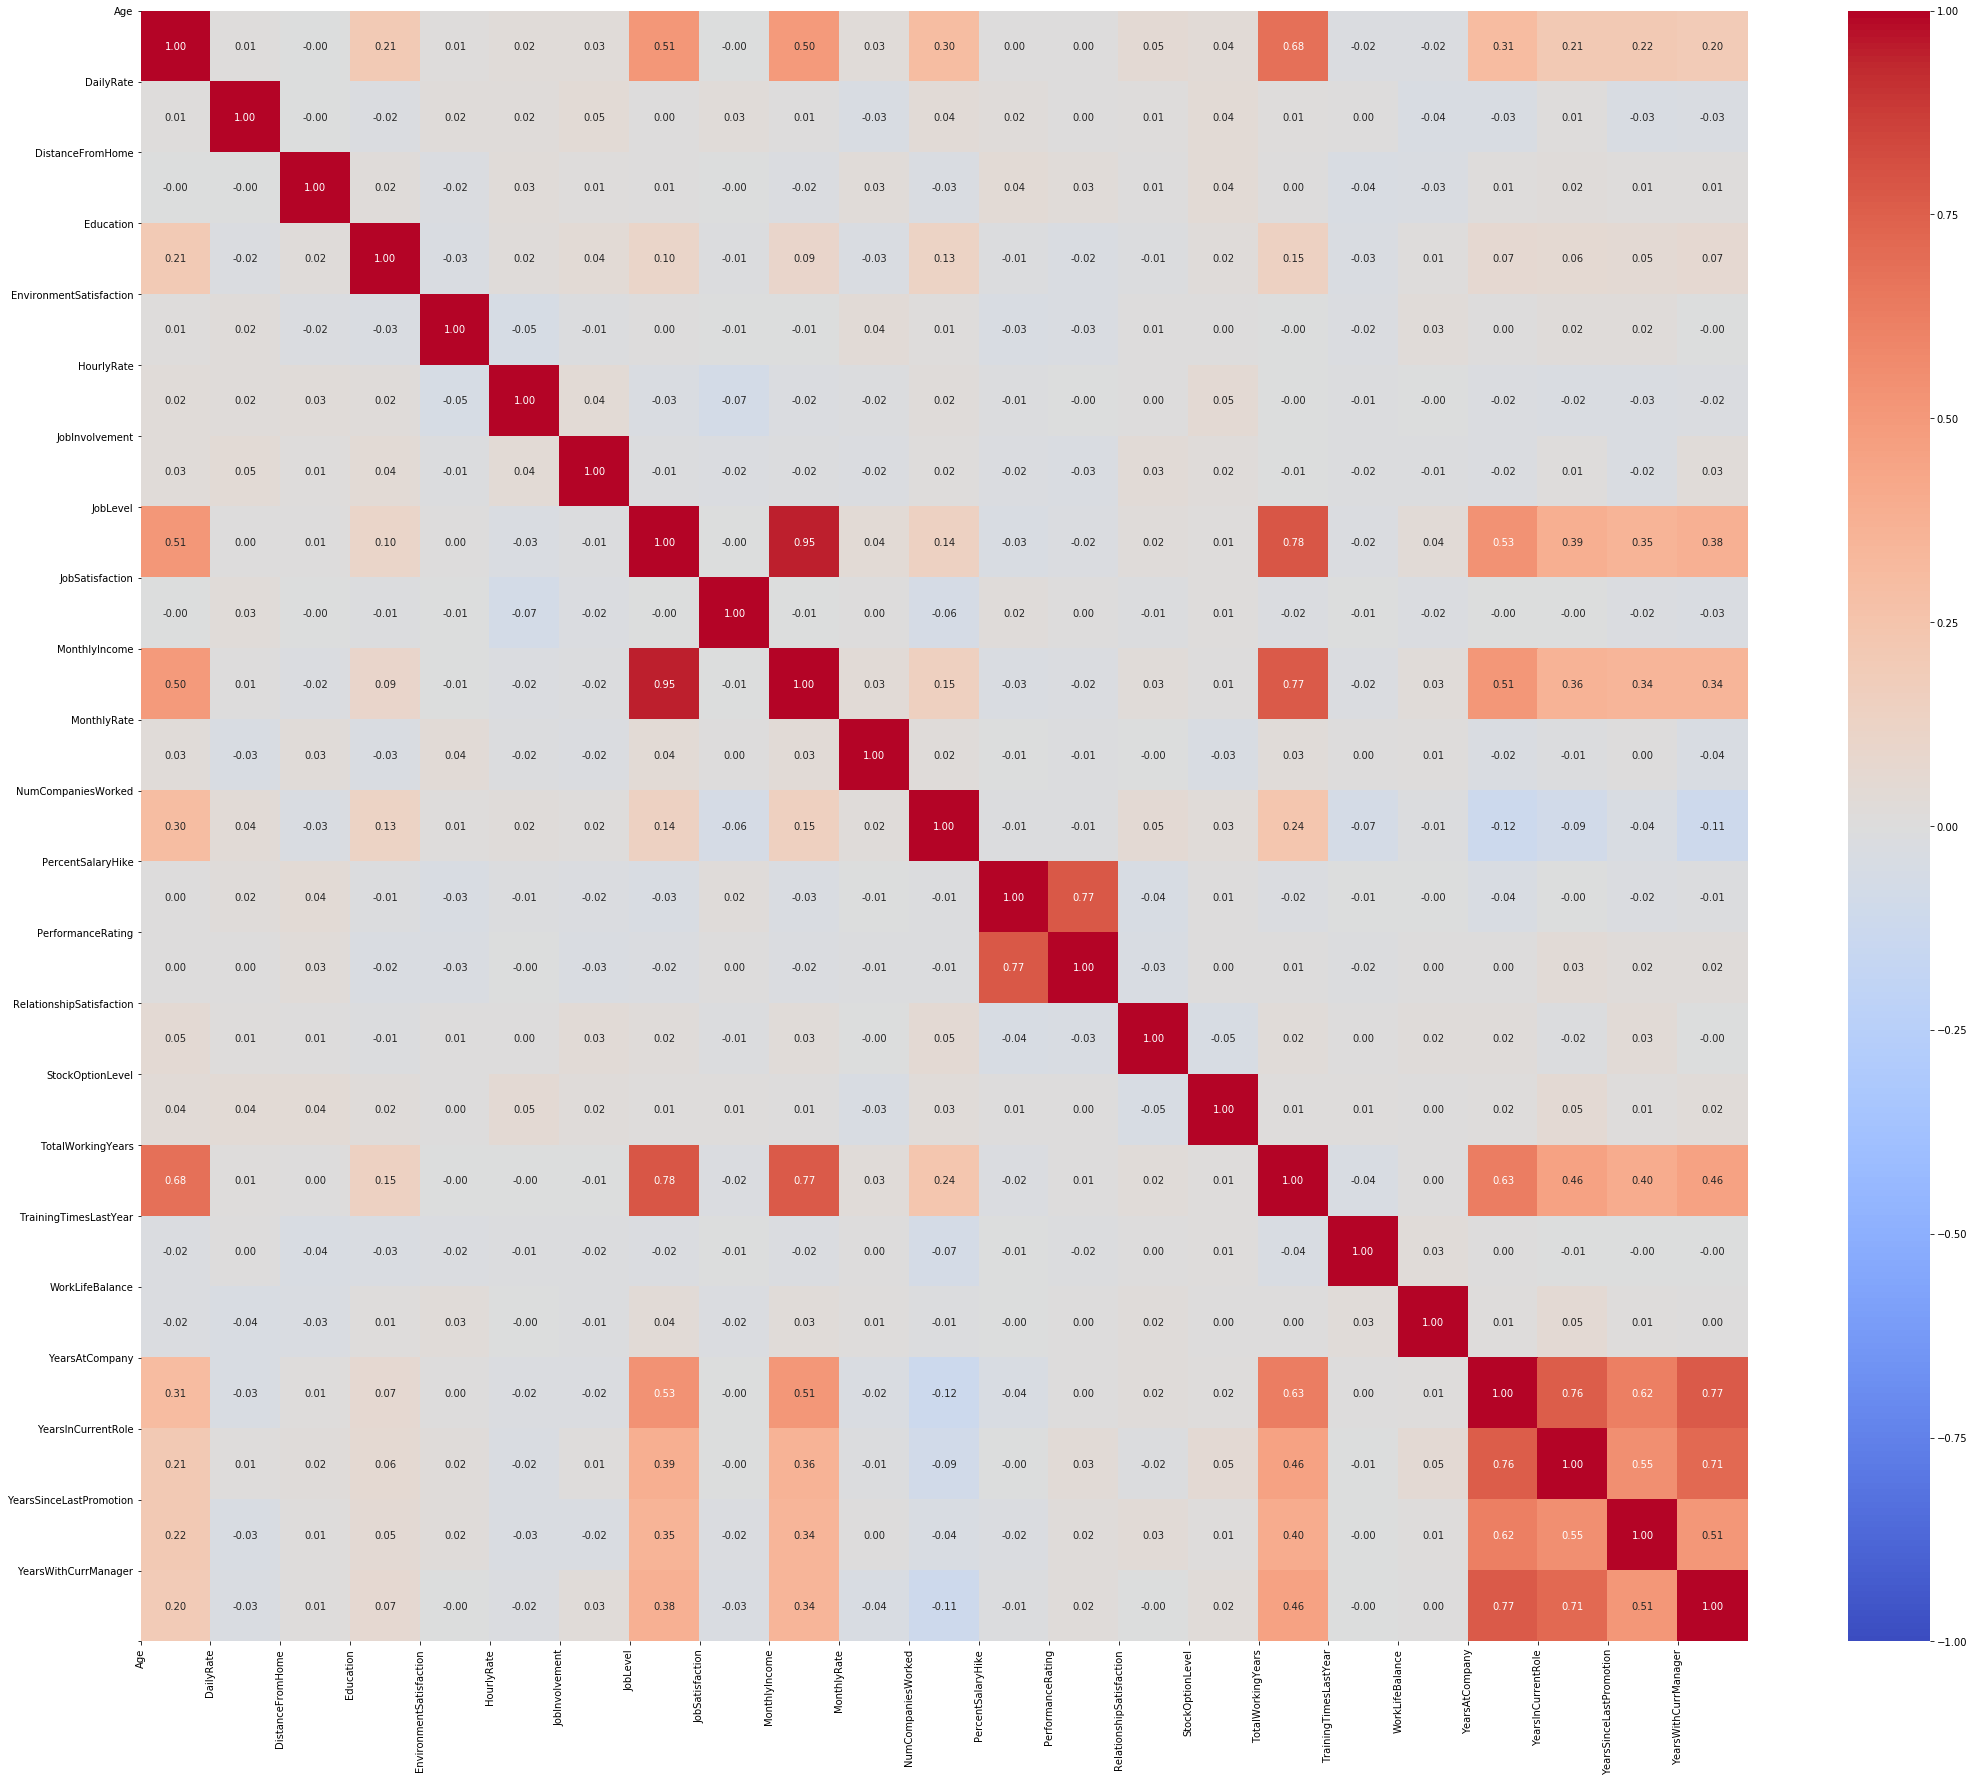

In [123]:
fig, ax = plt.subplots(figsize=(36, 30))

g = sns.heatmap(data[nums].corr(),cmap='coolwarm',annot=True, fmt=".2f", vmax = 1, vmin = -1, center= 0);

plt.xticks(range(len(data[nums].columns)), nums)

plt.yticks(range(len(data[nums].columns) + 1), nums)

plt.show()

#### Feature : Age

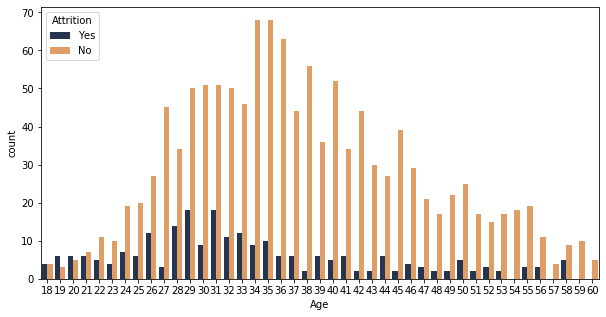

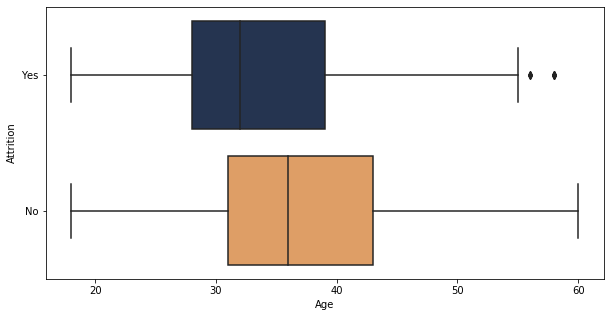

In [73]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'Age', data = data, hue = 'Attrition' )
plt.show()
plt.figure(figsize=(10,5))
sns.boxplot(x = 'Age', y = "Attrition", data = data)
plt.show()

The bar chart and box plot illustrates that the majority of people leaving due to burnout from work are in the range from 28 to 40 years. There are several outliers, but they also may be one of the key features for the target variable.
 That is why, it is necessary to construct normap distribution.

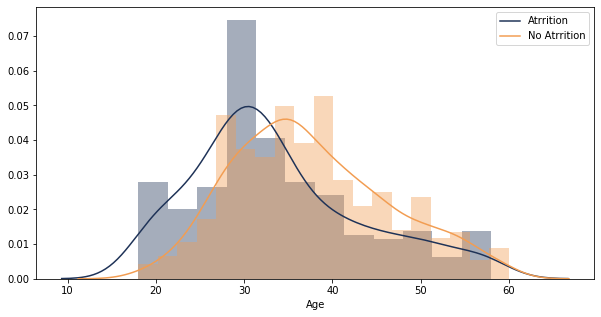

In [90]:
plt.figure(figsize=(10,5))
a = data[(data['Attrition'] == "Yes")]
n = data[(data['Attrition'] == "No")]
ax = sns.distplot(a['Age'], kde_kws = {"label": "Atrrition"})
f = sns.distplot(n['Age'], kde_kws = {"label": "No Atrrition"})
plt.show()

As you can see, the number of people over 55 in the company is gradually falling, therefore, we can assume that these are not emissions.

Below will be presented graphs of the interaction of the sign: age with others.

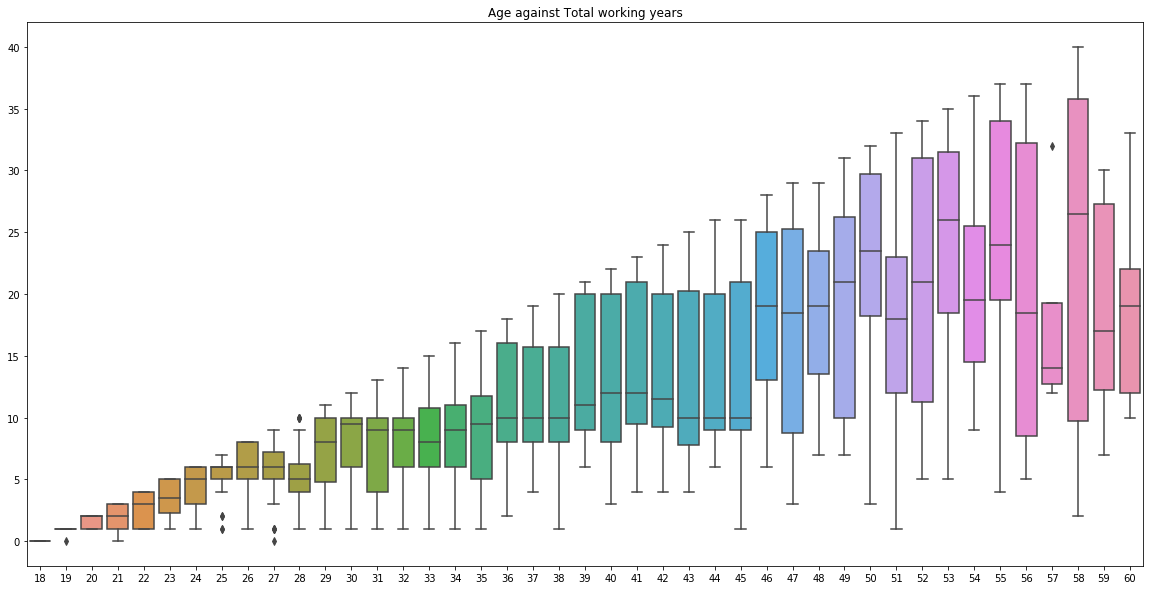

In [80]:
plt.figure(figsize=(20,10))
x = data['Age'].values
y = data['TotalWorkingYears'].values
ans = sns.boxplot(x, y)
ans.set( title = 'Age against Total working years')
plt.show()

The results are logical, there are upwards trend, since it is obvious that with age, the number of working years is also growing. However, an atypical drop in the number of years worked is observed in people of 57 years of age, and in people of 59 and 60 years of age. Moreover, there are some anomalies, for checking their importance. Need to construct a different graph.

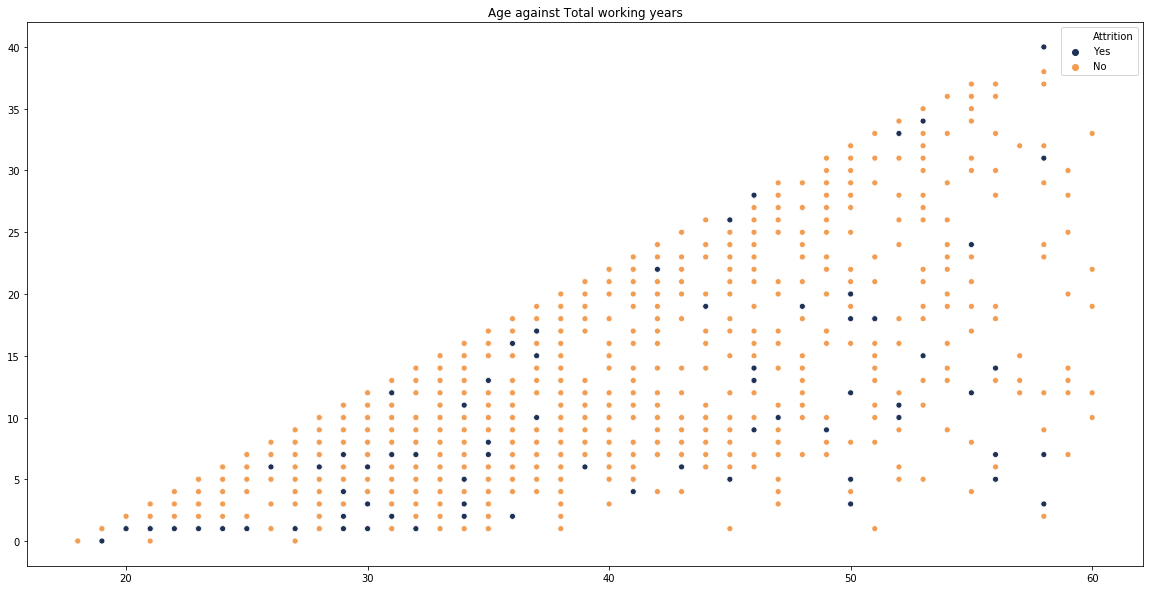

In [87]:
plt.figure(figsize=(20,10))
x = data['Age'].values
y = data['TotalWorkingYears'].values
ans = sns.scatterplot(x, y, hue = data['Attrition'])
ans.set( title = 'Age against Total working years')
plt.show()

The data that were displayed as outliers in the previous graph are not really them.

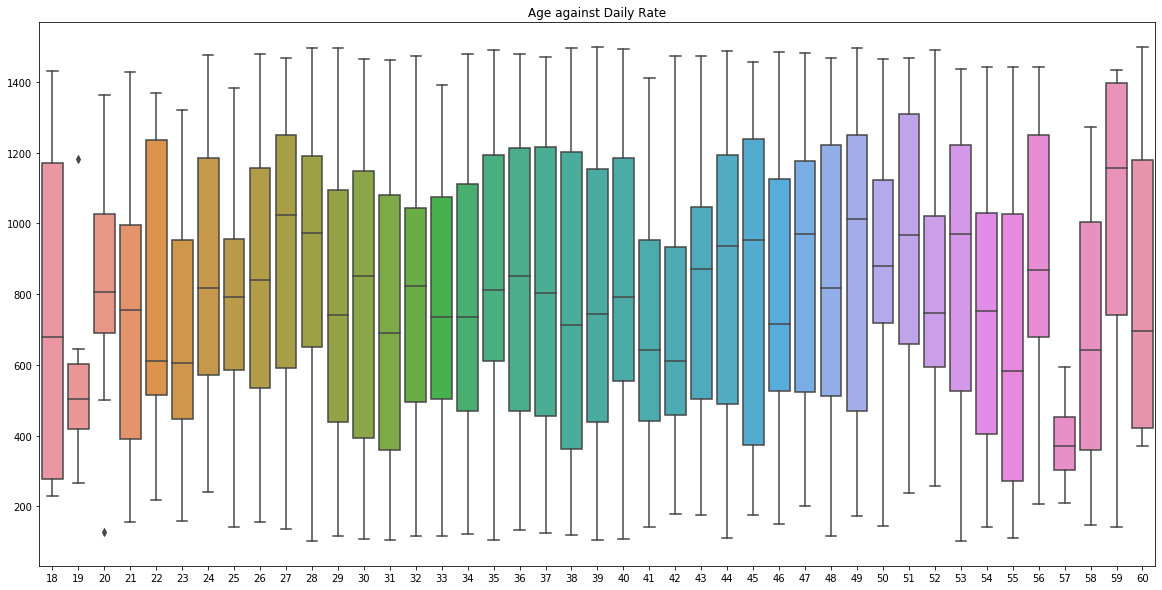

In [81]:
plt.figure(figsize=(20,10))
x = data['Age'].values
y = data['DailyRate'].values
ax = sns.boxplot(x, y)
ax.set( title = 'Age against Daily Rate')
plt.show()

Data on daily rates are very scattered and have a wide range, a small range is observed in people aged 19, 20 and 57. However, if we take into account the fact that people with 57 years of age have a small experience, then the low range of rates does not seem strange. In the graphs, people aged 19 and 20 have anomalies, let's look at it in more detail.

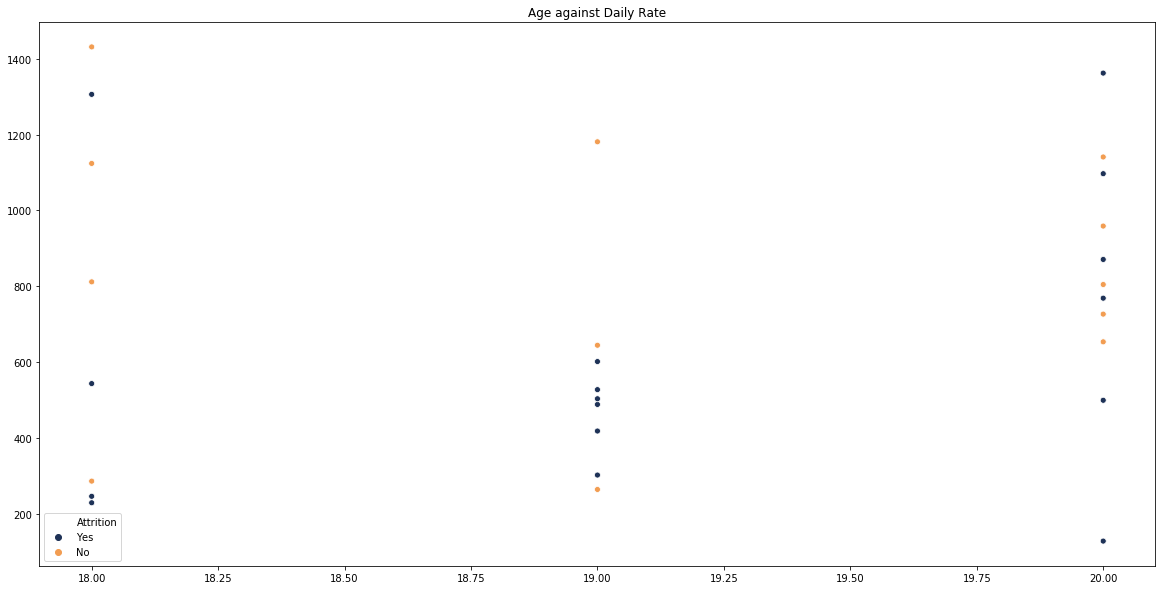

In [145]:
plt.figure(figsize=(20,10))
a = data['Age'] < 21
a1 = data.copy()
a1 = a1[a]
x = a1['Age'].values
y = a1['DailyRate'].values
ax = sns.scatterplot(x, y, hue = a1['Attrition'])
ax.legend()
ax.set( title = 'Age against Daily Rate')
plt.show()

Well, ouliers on the previous graph now vizualized in more details. Also, this outliers could be a important and we can't drop it.

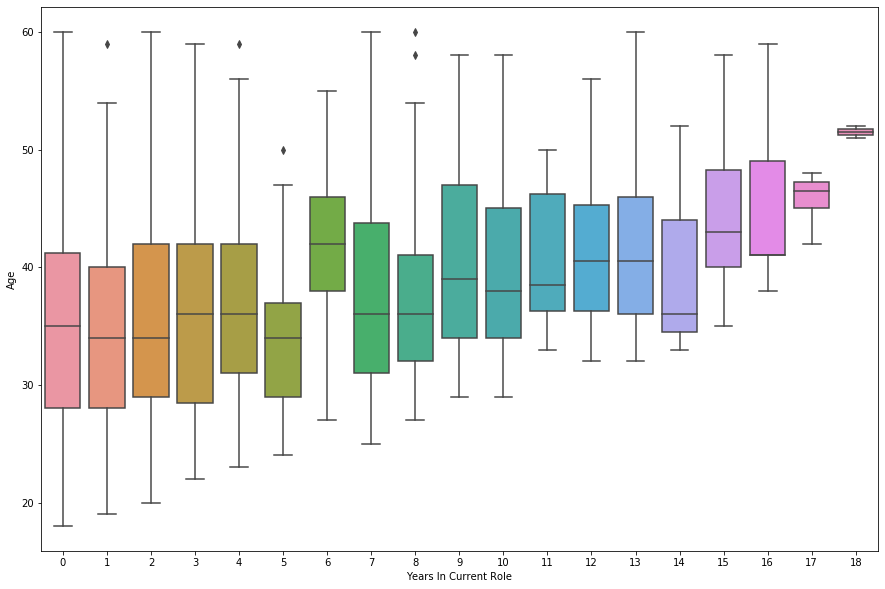

In [41]:
plt.figure(figsize=(15,10))
x = data['YearsInCurrentRole'].values
y = data['Age'].values
ax = sns.boxplot(x, y,)
ax.set_xlabel('Years In Current Role')
ax.set_ylabel('Age')
ax.set_title = ('Years in role against Age')
plt.show()

There is an upwards trend. People with experience up to 4 years have approximately the same median value. Interestingly, that there are counterintuitive results for people which is 15 years in current role. The median value is 32 years, however, the neighbours have median value 40 and ~ 42. There are several outliers which lay below 9 years in a current role, that is let's look at it at the scatterplot.

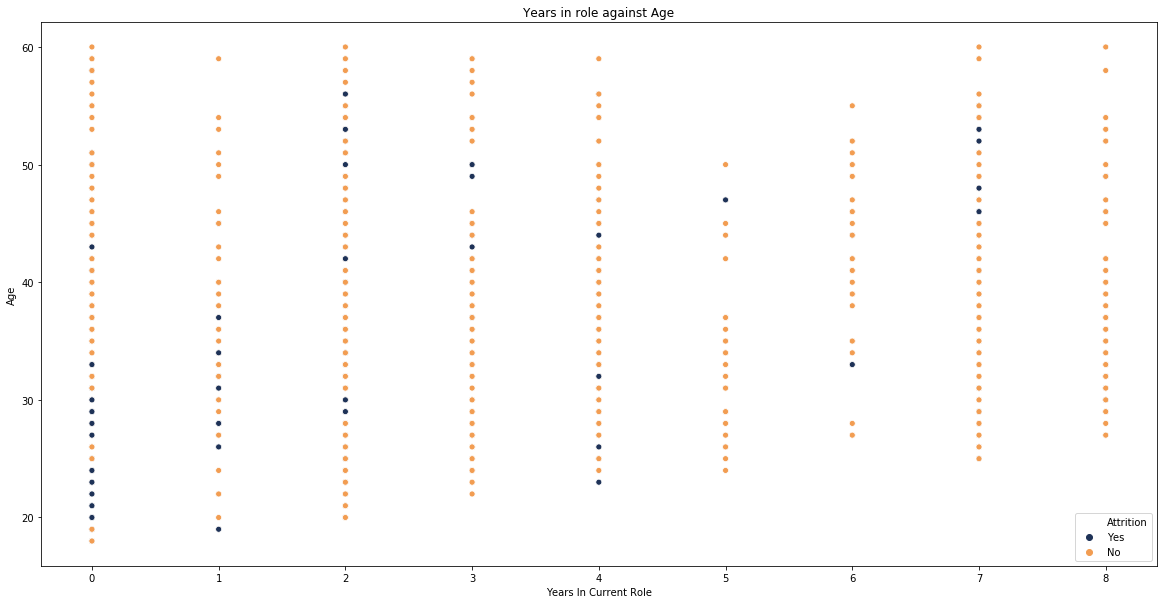

In [146]:
plt.figure(figsize=(20,10))
a = data['YearsInCurrentRole'] < 9
a1 = data.copy()
a1 = a1[a]
y = a1['Age'].values
x = a1['YearsInCurrentRole'].values
ax = sns.scatterplot(x, y, hue = a1['Attrition'])
ax.set_xlabel('Years In Current Role')
ax.set_ylabel('Age')
ax.legend()
ax.set( title = 'Years in role against Age')
plt.show()

It is mentionable, that the majority of people with Attrirtion have zero years in current role. There is no people with Attrirtion in outliers that is why they are not outliers.

#### Feature : Business Travel

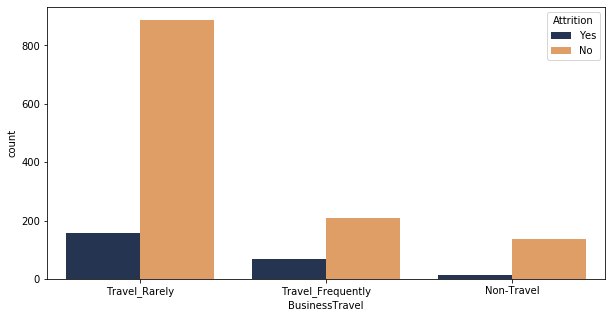

In [12]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'BusinessTravel', data = data, hue = 'Attrition' )
plt.show()

Most of the employees rarely travelled, so most of those who left are in this category. An interesting phenomenon is that the biggest difference in the percentage and no is observed in the graph of people who have not travelled. 

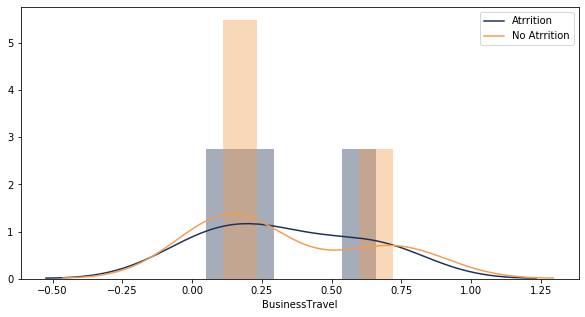

In [175]:
plt.figure(figsize=(10,5))
a = data[(data['Attrition'] == "Yes")]
n = data[(data['Attrition'] == "No")]
ax = sns.distplot(a['BusinessTravel'].value_counts(normalize=True), kde_kws = {"label": "Atrrition"}, bins=5)
f = sns.distplot(n['BusinessTravel'].value_counts(normalize=True), kde_kws = {"label": "No Atrrition"}, bins=5)
plt.show()

This grafic does not give a lot of significant information.

#### Feature : Department

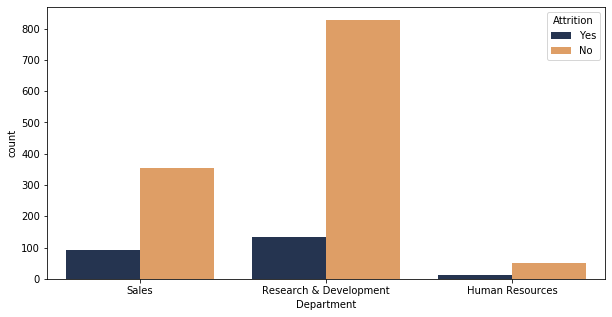

In [114]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'Department', data = data, hue = 'Attrition')
plt.show()


You may notice that the largest number of people work in the department. There is also the largest number of people who have left the company.

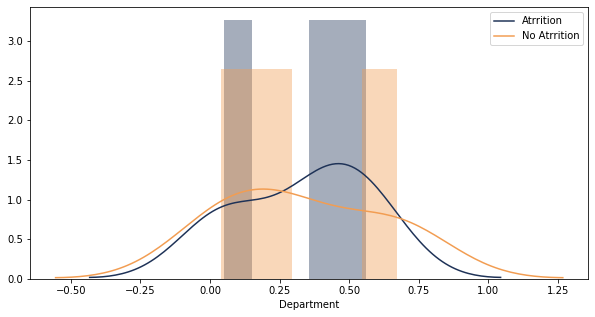

In [174]:
plt.figure(figsize=(10,5))
a = data[(data['Attrition'] == "Yes")]
n = data[(data['Attrition'] == "No")]
ax = sns.distplot(a['Department'].value_counts(normalize=True), kde_kws = {"label": "Atrrition"}, bins=5)
f = sns.distplot(n['Department'].value_counts(normalize=True), kde_kws = {"label": "No Atrrition"}, bins= 5)
plt.show()

This grafic does not give a lot of significant information.

Further, graphs of the interaction of departments with other features will be presented.

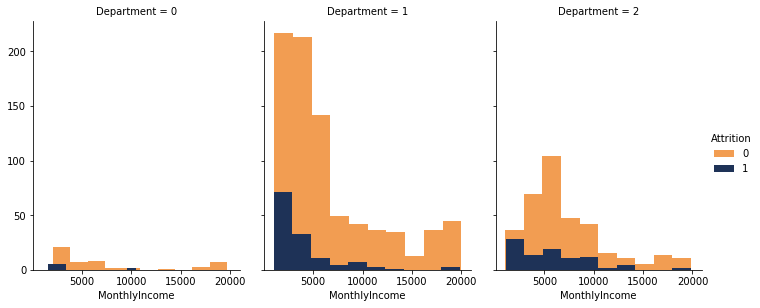

In [234]:
g = sns.FacetGrid(df, col="Department", hue="Attrition", hue_kws={'color': ["#f29d52","#1e3257"]})
g = g.map(plt.hist, "MonthlyIncome")
g.fig.set_size_inches(10,5)
g.add_legend()
plt.show()

As you can see, the income of people who left the company generally lies below 10,000. However, there are some anomalies, let's check them on another chart.

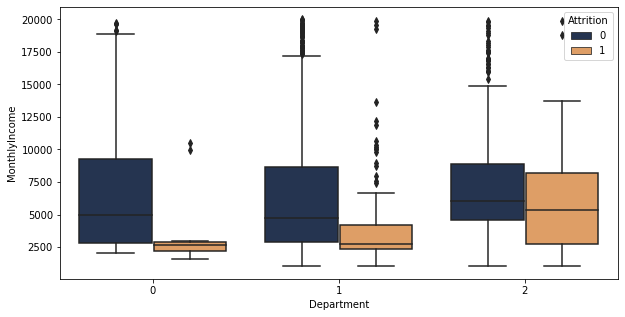

In [74]:
plt.figure(figsize=(10,5))
sns.boxplot(x = "Department", y = "MonthlyIncome", data = df, hue = "Attrition")
plt.show()

The graph shows a lot of anomalous values since the number of employees receiving about 20,000 is extremely small. And if we consider only those who left the company, then there are almost none, therefore this can interfere with the calculations. Let's look at the quantiles.

In [90]:
a = df[(df['Attrition'] == 1)]
b = a[a["Department"] == 0]
c = a[a["Department"] == 1]
d = a[a["Department"] == 2]
b_95 = np.percentile(b["MonthlyIncome"],95)
c_95 = np.percentile(c["MonthlyIncome"],95)
d_95 = np.percentile(d["MonthlyIncome"],95)

print(b_75, c_75, d_75)

10189.4 10447.199999999997 13052.1


#### Feature : Distance from Home

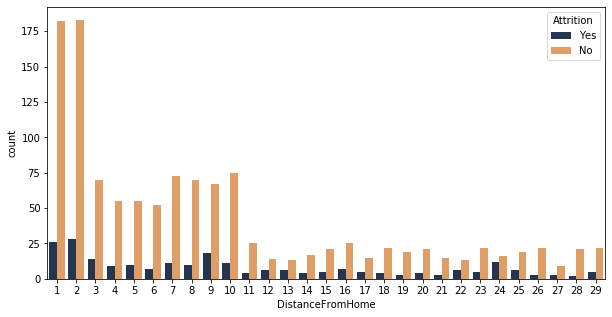

In [117]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'DistanceFromHome', data = data, hue = 'Attrition')
plt.show()

Most people live at a distance of no more than 11 units.

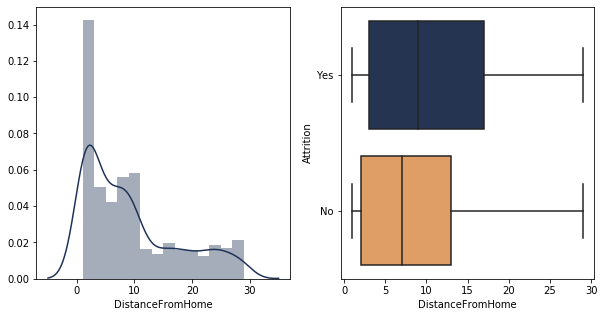

In [68]:
fig,ax=plt.subplots(1,2, figsize=(10,5))
sns.distplot(data['DistanceFromHome'], ax=ax[0])
sns.boxplot(x = 'DistanceFromHome', y = "Attrition", data = data)
plt.show()


It is mentionable that 75% of values are to the left of 15. People leave more if they live farther from work. Anomaly dosen't found.

#### Feature : Education

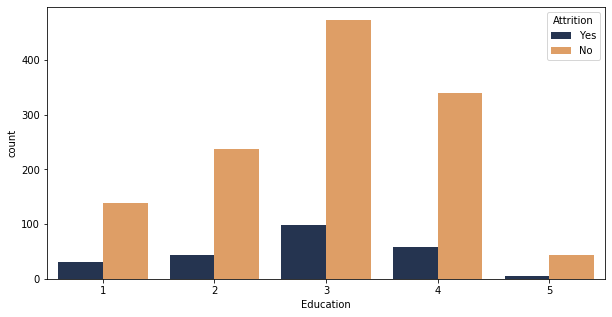

In [140]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'Education', data = data, hue = 'Attrition' )
plt.show()

The biggest part of people has Bachelor degree, and the smalest part is a people with a doctor degree. The tendency for people with Attrition is the same.

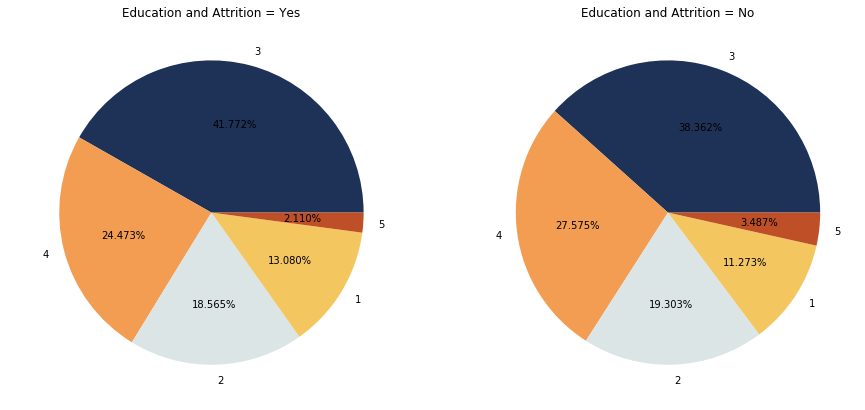

In [155]:
f,ax=plt.subplots(1,2, figsize=(15,10))
a = data[(data['Attrition'] == "Yes")]
n = data[(data['Attrition'] == "No")]
ax[0].set_title("Education and Attrition = Yes")
a.Education.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[0],label=' ')
n.Education.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[1], label=' ')
ax[1].set_title("Education and Attrition = No")
plt.show()

There is no such a big persentage difference in Education according to Atrrition values this is support previous conclusion about the same tendency in quantity of people with difference education degree.

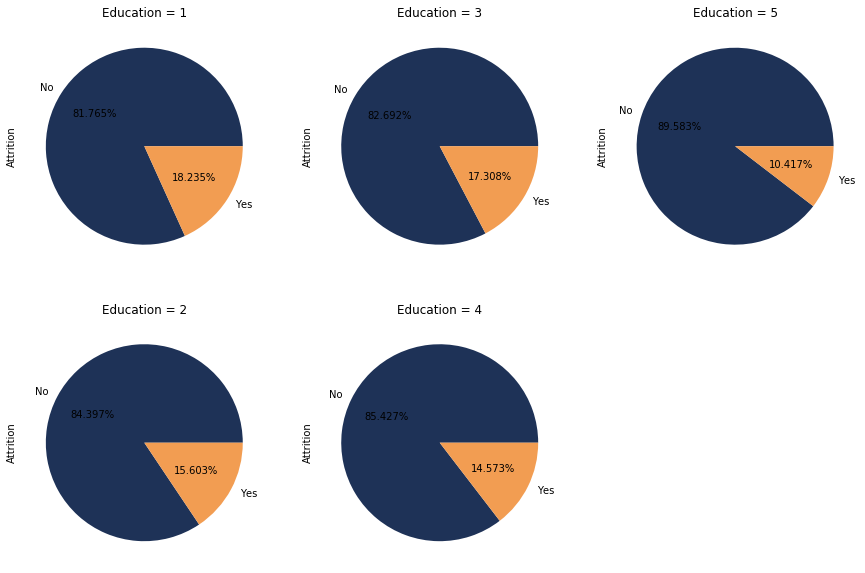

In [228]:
f,ax=plt.subplots(2,3, figsize=(15,10))
data[data['Education']== 1].Attrition.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[0][0])
ax[0][0].set_title("Education = 1")
data[data['Education']== 2].Attrition.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[1][0])
ax[1][0].set_title("Education = 2")
data[data['Education']== 3].Attrition.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[0][1])
ax[0][1].set_title("Education = 3")
data[data['Education']== 4].Attrition.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[1][1])
ax[1][1].set_title("Education = 4")
data[data['Education']== 5].Attrition.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[0][2])
ax[0][2].set_title("Education = 5")
f.delaxes(ax[1, 2])
plt.show()

 People with Bachalor degree and with under colledge education have the biggest share of people who left. Category of People with Doctor degree has the smallest part of people with Attririon.

#### Feature : Education Field

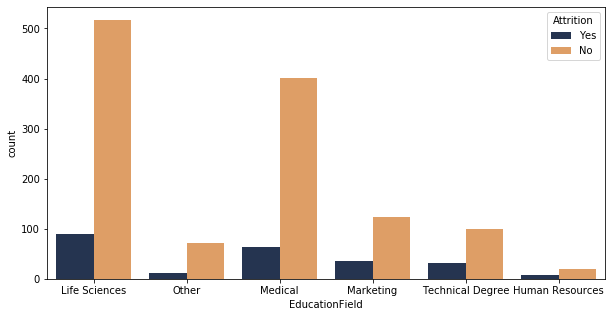

In [43]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'EducationField', data = data, hue = 'Attrition' )
plt.show()

The Large part of people get education in two directions life Sciences and Medical. About 70 percent of employees have education in these two areas.  The number of People who have education in Human Resources are less that 2 percents.

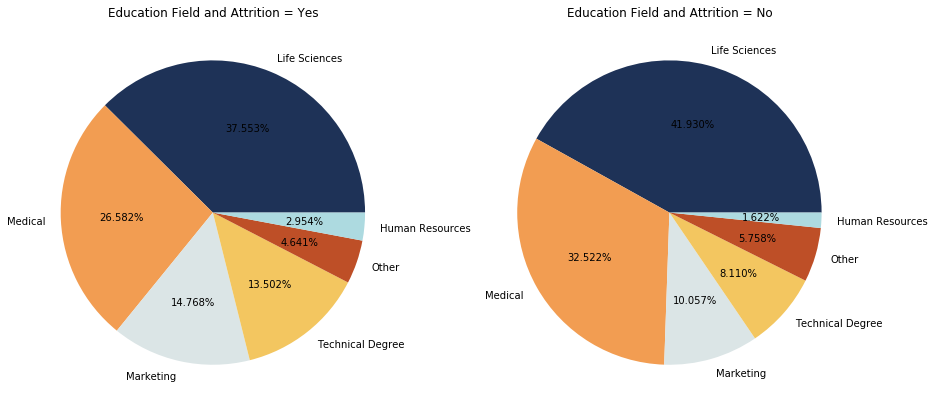

In [154]:
f,ax=plt.subplots(1,2, figsize=(15,10))
a = data[(data['Attrition'] == "Yes")]
n = data[(data['Attrition'] == "No")]
ax[0].set_title("Education Field and Attrition = Yes")
a.EducationField.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[0],label=' ')
n.EducationField.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[1], label=' ')
ax[1].set_title("Education Field and Attrition = No")
plt.show()

There is no such a big persentage difference in Education field according to Atrrition values.

#### Feature : Environment  Satisfaction

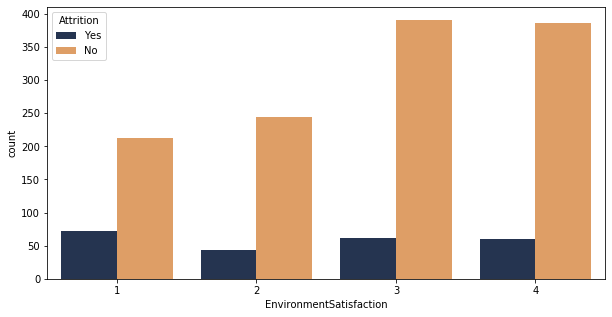

In [196]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'EnvironmentSatisfaction', data = data, hue = 'Attrition' )
plt.show()

The number of people with hiest environmental satisfaction is the biggest. In addition to it, the significant part of people with attririon have lowest Environment Satisfaction.

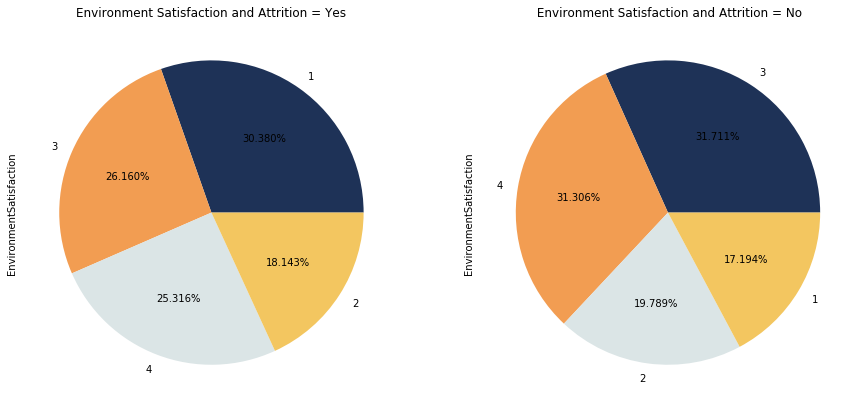

In [91]:
f,ax=plt.subplots(1,2, figsize=(15,10))
a = data[(data['Attrition'] == "Yes")]
n = data[(data['Attrition'] == "No")]
ax[0].set_title("Environment Satisfaction and Attrition = Yes")
a.EnvironmentSatisfaction.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[0])
n.EnvironmentSatisfaction.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[1])
ax[1].set_title(" Environment Satisfaction and Attrition = No")
plt.show()

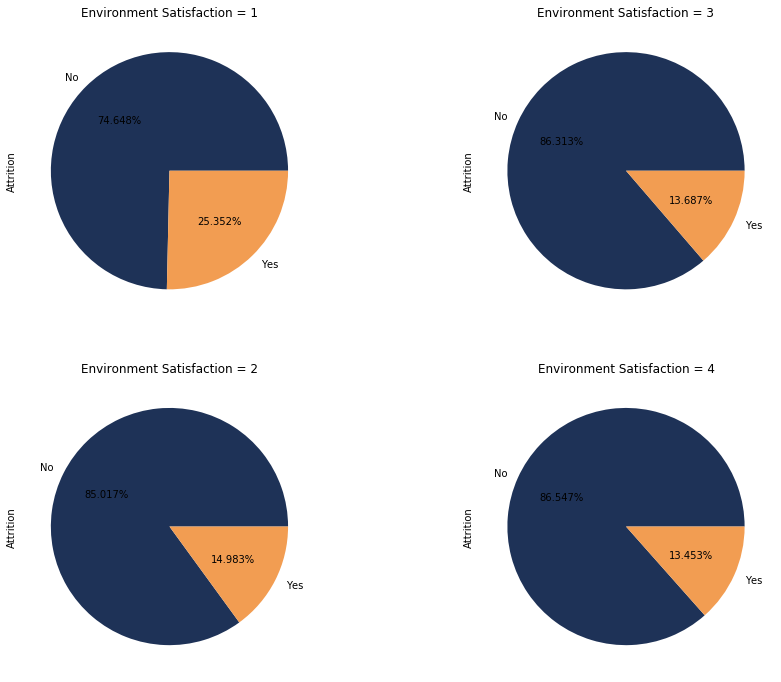

In [224]:
f,ax=plt.subplots(2,2, figsize=(15,12))
data[data['EnvironmentSatisfaction']== 1].Attrition.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[0][0])
ax[0][0].set_title("Environment Satisfaction = 1")
data[data['EnvironmentSatisfaction']== 2].Attrition.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[1][0])
ax[1][0].set_title("Environment Satisfaction = 2")
data[data['EnvironmentSatisfaction']== 3].Attrition.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[0][1])
ax[0][1].set_title("Environment Satisfaction = 3")
data[data['EnvironmentSatisfaction']== 4].Attrition.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[1][1])
ax[1][1].set_title("Environment Satisfaction = 4")
plt.show()

The level of satisfaction within the company shows that people who left the position frequent rated lower than those who continued to work.

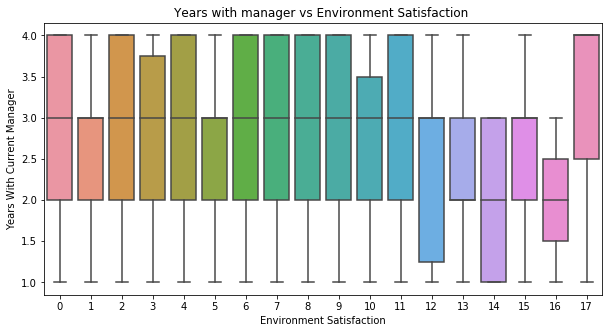

In [98]:
plt.figure(figsize=(10,5))
y = data['EnvironmentSatisfaction'].values
x = data['YearsWithCurrManager'].values
ax = sns.boxplot(x, y)
ax.set_xlabel('Environment Satisfaction')
ax.set_ylabel('Years With Current Manager')
ax.set( title = 'Years with manager vs Environment Satisfaction ')
plt.show()

The average value is 3, but there are strange, not typical results for people working with a manager for 12,14,16 years. Scores below the average in 75 percent of people.

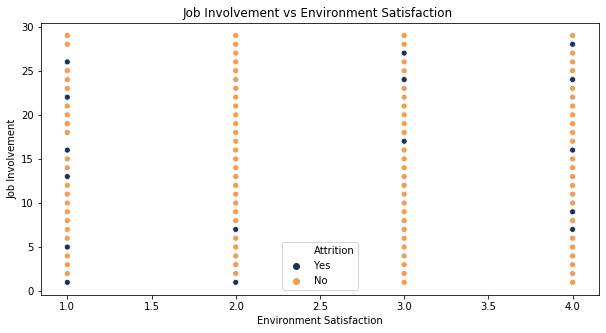

In [145]:
plt.figure(figsize=(10,5))
x = data['EnvironmentSatisfaction'].values
y = data['DistanceFromHome'].values
ax = sns.scatterplot(x, y, hue = data['Attrition'])
ax.set_xlabel('Environment Satisfaction')
ax.set_ylabel('JDistance From Home')
ax.set( title = 'Distance From Home vs Environment Satisfaction ')
plt.show()

This chart is noninformative

#### Feature : Gender

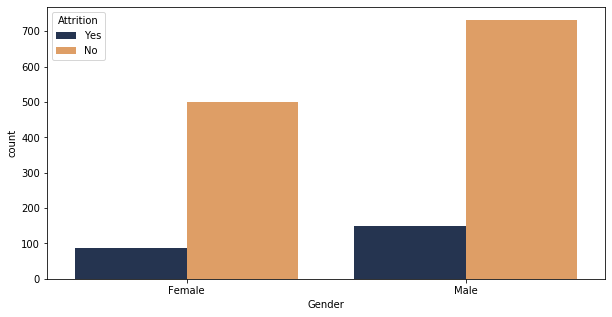

In [158]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'Gender', data = data, hue = 'Attrition' )
plt.show()

The bar chart shows that the most of the company’s employees are men.

#### Feature :  Hourly Rate

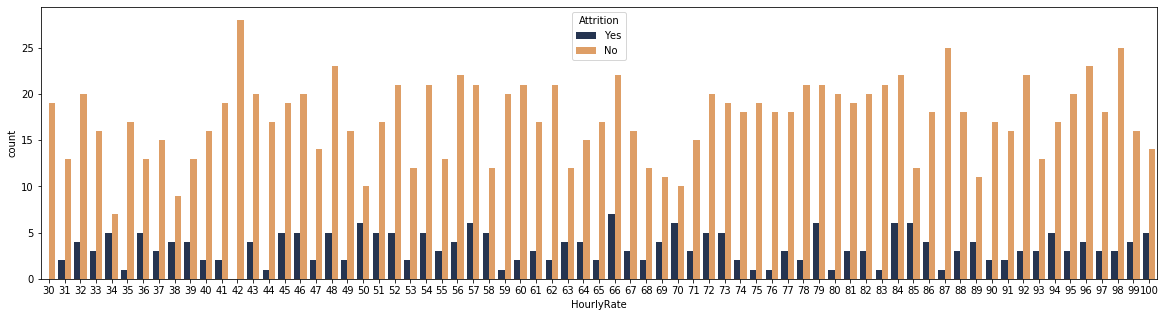

In [173]:
plt.figure(figsize=(20,5))
sns.countplot(x = 'HourlyRate', data = data, hue = 'Attrition' )
plt.show()


The largest number of employees have a rate of 42 hours. An interesting fact, that among people at a rate of 42 hours there are no those who have left.

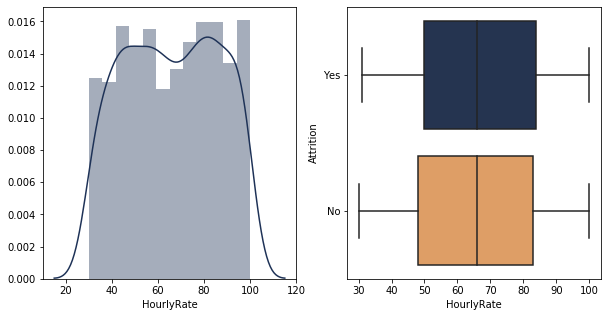

In [126]:
fig,ax=plt.subplots(1,2, figsize=(10,5))
sns.distplot(data['HourlyRate'], ax=ax[0])
sns.boxplot(x = 'HourlyRate',y = 'Attrition', data = data)
plt.show()

In general, the median value of people who have left and not gone is equal. However, if you look at 25 and 75 quantiles, then the value of the rates of laid-off people is higher

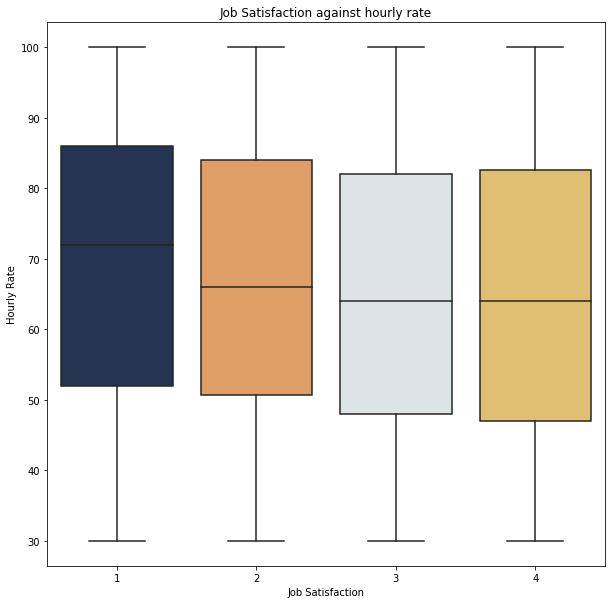

In [190]:
plt.figure(figsize=(10,10))
y = data['HourlyRate'].values
x = data['JobSatisfaction'].values
ax = sns.boxplot(x, y)
ax.set_xlabel('Job Satisfaction')
ax.set_ylabel('Hourly Rate')
ax.set( title = 'Job Satisfaction against hourly rate')
plt.show()

People with a higher hourly rate are generally less satisfied with their work. There is also a downward trend that people with a lower bid tend to rate   job better.

#### Feature : Job Satisfaction

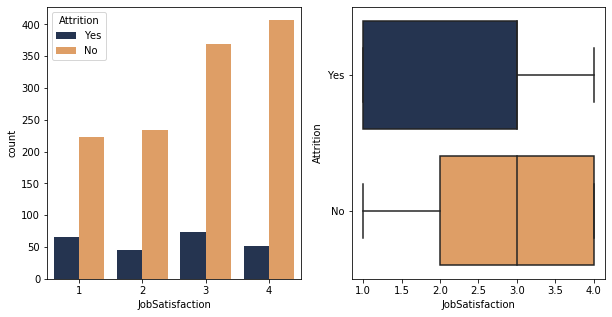

In [125]:
fig,ax=plt.subplots(1,2, figsize=(10,5))
sns.countplot(x = 'JobSatisfaction',data = data, hue = 'Attrition', ax=ax[0])
sns.boxplot(x = 'JobSatisfaction', y = 'Attrition',  data = data)
plt.show()

People leaving work tend to rate work much lower than those who stayed to work there.

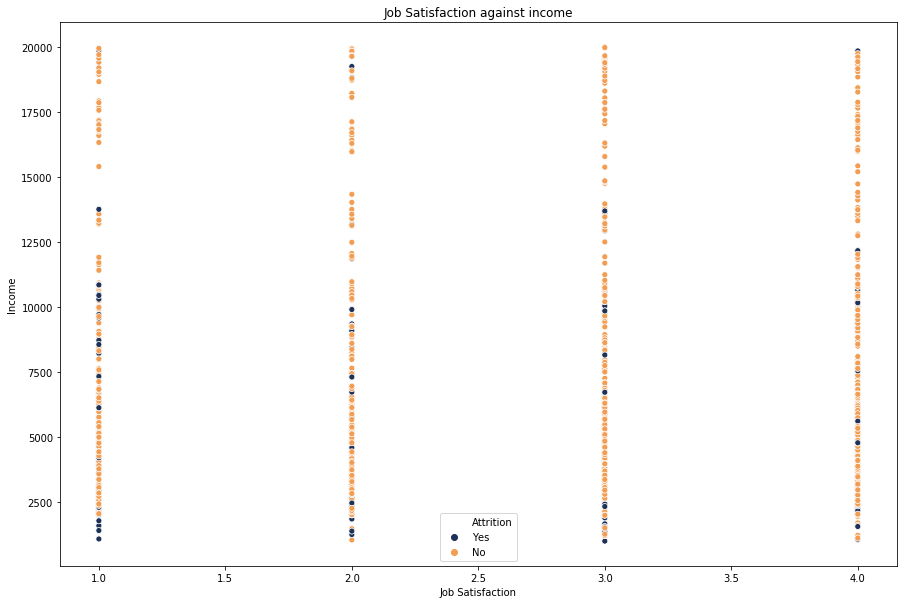

In [57]:
plt.figure(figsize=(15,10))
y = data['MonthlyIncome'].values
x = data['JobSatisfaction'].values
ax = sns.scatterplot(x, y, hue = data["Attrition"])
ax.set_xlabel('Job Satisfaction')
ax.set_ylabel('Income')
ax.set( title = 'Job Satisfaction against income')
plt.show()

People who left put in most cases worse than grades, also many of them had low income

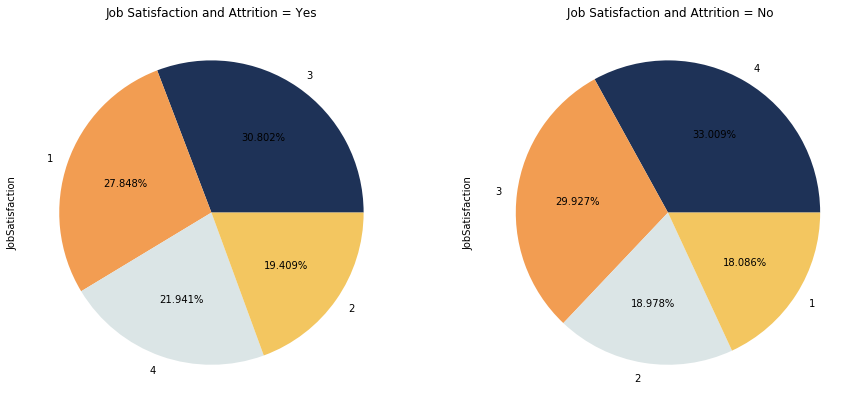

In [209]:
f,ax=plt.subplots(1,2, figsize=(15,10))
a = data[(data['Attrition'] == "Yes")]
n = data[(data['Attrition'] == "No")]
ax[0].set_title("Job Satisfaction and Attrition = Yes")
a.JobSatisfaction.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[0])
n.JobSatisfaction.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[1])
ax[1].set_title(" Job Satisfaction and Attrition = No")
plt.show()

Most of the values are allocated to grades 3 and 4, this can be seen by relative to hourly rates. People with lower rates also have more positive satisfaction ratings. You can also notice that those who left most of them take grades 1 and 3.

#### Feature : Job Involvement

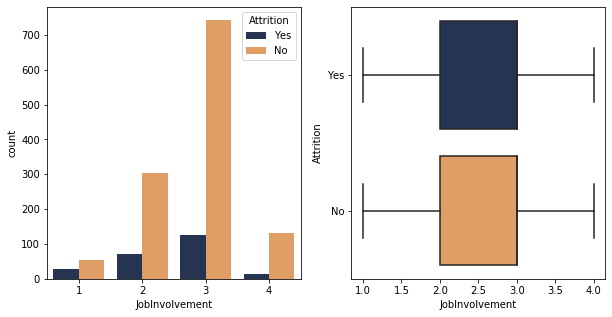

In [124]:
fig,ax=plt.subplots(1,2, figsize=(10,5))
sns.countplot(x = 'JobInvolvement',data = data, hue = 'Attrition', ax=ax[0])
sns.boxplot(x = 'JobInvolvement',y = 'Attrition', data = data)
plt.show()

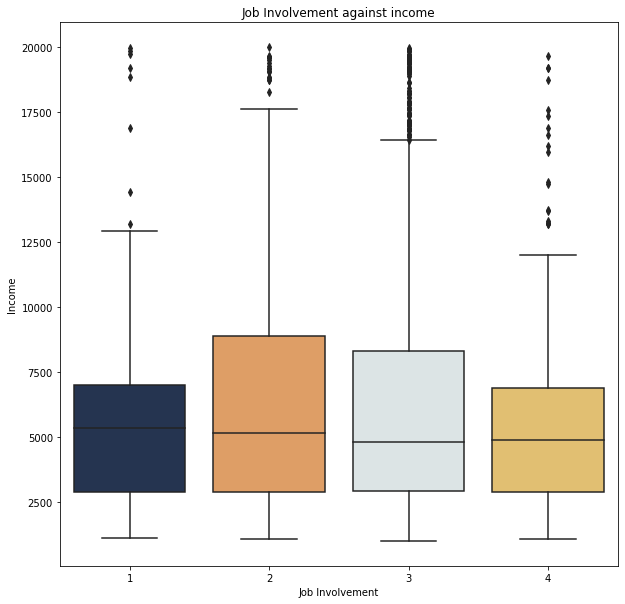

In [218]:
plt.figure(figsize=(10,10))
y = data['MonthlyIncome'].values
x = data['JobInvolvement'].values
ax = sns.boxplot(x, y)
ax.set_xlabel('Job Involvement')
ax.set_ylabel('Income')
ax.set( title = 'Job Involvement against income')
plt.show()

It is mentionable that a larger amount of data is distributed on blocks 2 and 3. Also there is a large amount of outliners. 
Based on this, Monthly income has too much data scatter.

#### Feature : Marital Status

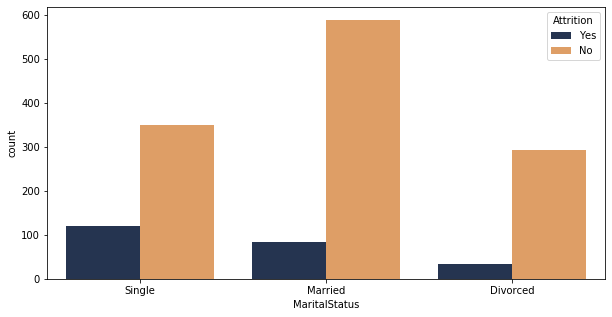

In [219]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x = 'MaritalStatus', data = data, hue = 'Attrition')

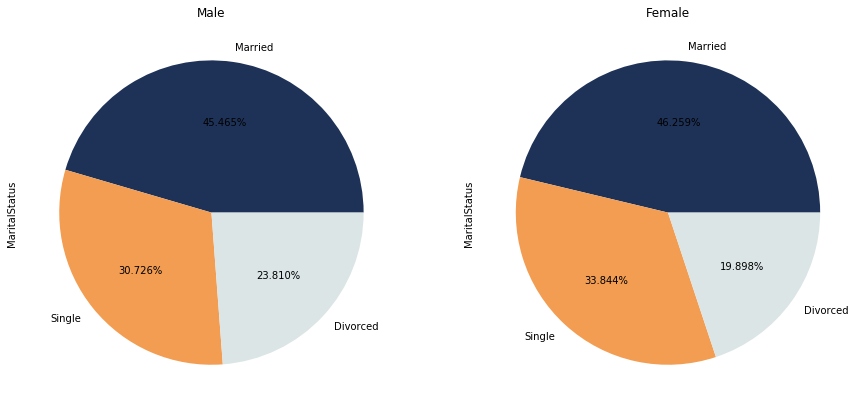

In [225]:
f,ax=plt.subplots(1,2, figsize=(15,10))
a = data[(data['Gender'] == "Male")]
n = data[(data['Gender'] == "Female")]
ax[0].set_title('Male')
a.MaritalStatus.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[0])
n.MaritalStatus.value_counts().plot.pie(autopct='%1.3f%%', ax = ax[1])
ax[1].set_title("Female")
plt.show()

There is no such a big persentage difference in Gender according to Atrrition values.

# Part 2 : Applying differend machine learning models

Before constructing the model we have to convert categorical columns into number columns and label our target.

In [148]:
df = data.copy()
l = LabelEncoder()
for i in categ:
    df[i] = l.fit_transform(df[i])

In [149]:
x = df.drop('Attrition', axis=1)
y = df.Attrition

In [150]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state =  0)

Since our data is not balanced, we can try some modern solution which is make data more balanced. We will use smote solution for this. The futher calculations are going represented in two solution with smote and without.

In [151]:
from imblearn.over_sampling import SMOTE

oversampler = SMOTE(random_state=0)

smote_train, smote_target = oversampler.fit_sample(x_train, y_train)

### First model : Random Forest.

For this model I am going to use cross validaton method and split data set into 10 folds.

In [102]:
k_f = KFold(n_splits = 10, shuffle=True, random_state = 0)

In [156]:
randfor = RandomForestClassifier(n_estimators = 1000)
randfor.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [157]:
print("Validation test:")
cv = (cross_val_score(randfor, x_train, y_train, cv=k_f, n_jobs=1, scoring = 'accuracy').mean())
print(cv)

Validation test:
0.8621324062002028


In [158]:
pred_test = randfor.predict(x_test)
metrics.f1_score(y_test, pred_test)

0.27118644067796605

In [159]:
print("Accuracy: {}".format(metrics.accuracy_score(y_test, pred_test)))

Accuracy: 0.8537414965986394


In [160]:
randfor.fit(smote_train, smote_target)
pred_test_sm = randfor.predict(x_test)
metrics.f1_score(y_test, pred_test_sm)

0.425

In [161]:
print("Accuracy: {}".format(metrics.accuracy_score(y_test, pred_test_sm)))

Accuracy: 0.8435374149659864


It is mentionable, that with "smote" tha accuracy decreased and the value of Fmera grew up.

Text(0.5, 15.0, 'Predicted label')

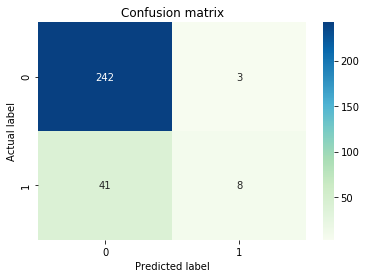

In [128]:
cnf = metrics.confusion_matrix(y_test, pred_test)
p = sns.heatmap(pd.DataFrame(cnf), annot=True, cmap= "GnBu" ,fmt='g')
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

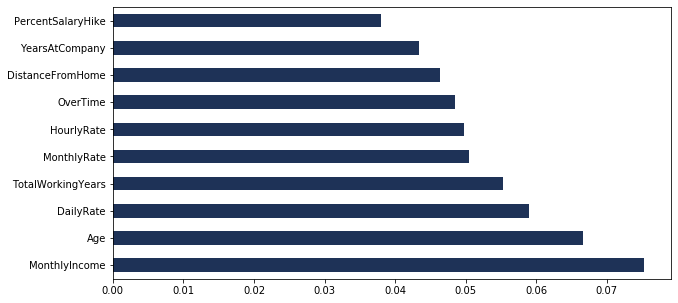

In [106]:
plt.figure(figsize=(10,5))
ax = pd.Series(randfor.feature_importances_, index = x.columns)
ax.nlargest(10).plot(kind = 'barh')
plt.show()

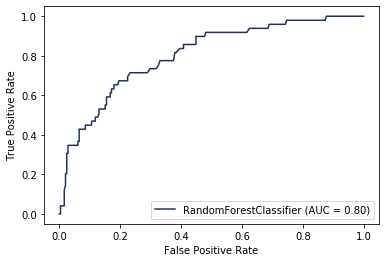

In [189]:
metrics.plot_roc_curve(randfor, x_test, y_test)
plt.show()

### Second model: Support Vector Machines

In [98]:
model1 = svm.SVC(random_state = 0)

In [99]:
model1.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [100]:
pred_test1 = model1.predict(x_test)
print("Accuracy: {}".format(metrics.accuracy_score(y_test, pred_test1)))

Accuracy: 0.8333333333333334


In [101]:
metrics.f1_score(y_test, pred_test1)

0.0

In [140]:
model1.fit(smote_train, smote_target)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [141]:
red_test1 = model1.predict(x_test)
print("Accuracy: {}".format(metrics.accuracy_score(y_test, pred_test1)))

Accuracy: 0.8333333333333334


In [142]:
metrics.f1_score(y_test, pred_test1)

0.0

Text(0.5, 15.0, 'Predicted label')

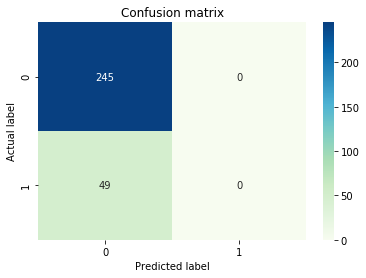

In [129]:
cnf = metrics.confusion_matrix(y_test, pred_test1)
p = sns.heatmap(pd.DataFrame(cnf), annot=True, cmap= "GnBu" ,fmt='g')
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

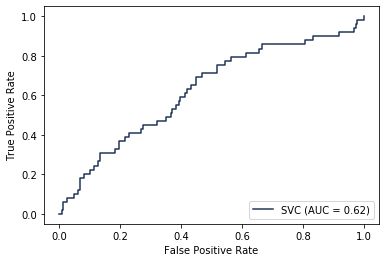

In [190]:
metrics.plot_roc_curve(model1, x_test, y_test)
plt.show()

### Third model : Extra Trees Classifier

In [84]:
trcl = ExtraTreesClassifier()
trcl.fit(x_train,y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [85]:
pred_test2 = trcl.predict(x_test)
print("Accuracy: {}".format(metrics.accuracy_score(y_test, pred_test2)))

Accuracy: 0.8571428571428571


In [88]:
metrics.f1_score(y_test, pred_test2)

0.27586206896551724

Text(0.5, 15.0, 'Predicted label')

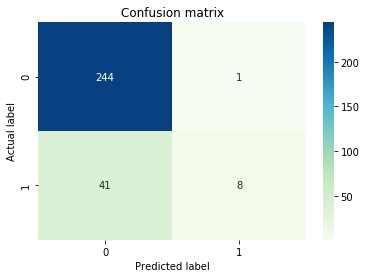

In [126]:
cnf = metrics.confusion_matrix(y_test, pred_test2)
p = sns.heatmap(pd.DataFrame(cnf), annot=True, cmap= "GnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

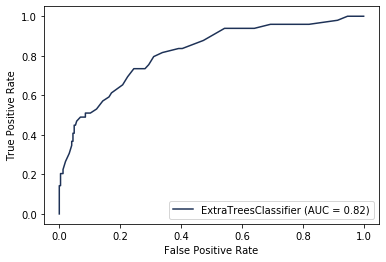

In [192]:
metrics.plot_roc_curve(trcl, x_test, y_test)
plt.show()

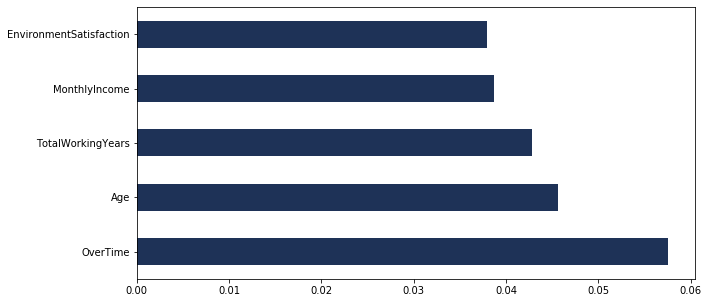

In [127]:
plt.figure(figsize=(10,5))
x = df.drop('Attrition', axis=1)
ax = pd.Series(trcl.feature_importances_, index = x.columns)
ax.nlargest(5).plot(kind = 'barh')
plt.show()